In [8]:
!pip install tensorflow
!pip install opencv-python
!pip install opencv-python-headless
!pip install moviepy
!pip install scikit-learn


In [9]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Cricket Dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import moviepy.editor as mp

In [2]:
# Function to extract frames from video
def extract_frames(video_path, frame_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frames.append(frame)
    cap.release()
    return frames

In [3]:
# Function to pad or truncate frames to a fixed length
def pad_or_truncate_frames(frames, max_length=16, frame_size=(224, 224)):
    num_frames = len(frames)
    if num_frames >= max_length:
        return frames[:max_length]
    else:
        padding = [np.zeros(frame_size + (3,), dtype=np.uint8)] * (max_length - num_frames)
        return frames + padding


In [4]:
# Prepare dataset
data = []
labels = []
shot_types = ['cover', 'defense', 'flick', 'hook', 'lofted', 'pull']
base_path = '/content/drive/MyDrive/Cricket Dataset/'

max_length = 16  # Fixed number of frames per sequence

for label, shot_type in enumerate(shot_types):
    shot_path = os.path.join(base_path, shot_type)
    for video_file in os.listdir(shot_path):
        video_path = os.path.join(shot_path, video_file)
        frames = extract_frames(video_path)
        frames = pad_or_truncate_frames(frames, max_length)
        data.append(frames)
        labels.append(label)

In [5]:
# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [6]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


In [7]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.3 MB/s eta 0:00:00


In [8]:
# Define MobileNetV2 model for video classification
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Create a custom model for video classification
input_shape = (max_length, 224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.TimeDistributed(base_model)(inputs)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(x)
x = tf.keras.layers.LSTM(512)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(shot_types), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)


In [10]:
# Train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])

Epoch 1/50
29/29 [==============================] - 26s 618ms/step - loss: 1.8467 - accuracy: 0.1956 - val_loss: 1.7323 - val_accuracy: 0.2800
Epoch 2/50
29/29 [==============================] - 15s 513ms/step - loss: 1.5841 - accuracy: 0.3222 - val_loss: 1.7419 - val_accuracy: 0.3244
Epoch 3/50
29/29 [==============================] - 15s 514ms/step - loss: 1.5023 - accuracy: 0.3567 - val_loss: 1.5853 - val_accuracy: 0.3289
Epoch 4/50
29/29 [==============================] - 15s 515ms/step - loss: 1.4771 - accuracy: 0.3811 - val_loss: 1.5270 - val_accuracy: 0.3556
Epoch 5/50
29/29 [==============================] - 15s 515ms/step - loss: 1.4054 - accuracy: 0.4278 - val_loss: 1.5309 - val_accuracy: 0.3333
Epoch 6/50
29/29 [==============================] - 15s 515ms/step - loss: 1.3588 - accuracy: 0.4378 - val_loss: 1.5404 - val_accuracy: 0.3422
Epoch 7/50
29/29 [==============================] - 15s 517ms/step - loss: 1.3138 - accuracy: 0.4644 - val_loss: 1.4322 - val_accuracy: 0.3733

In [11]:
# Evaluation
y_val_pred = np.argmax(model.predict(X_val), axis=1)
report = classification_report(y_val, y_val_pred, target_names=shot_types)
conf_matrix = confusion_matrix(y_val, y_val_pred)

8/8 [==============================] - 5s 359ms/step


In [12]:
# Print performance summaries
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

       cover       0.49      0.42      0.45        40
     defense       0.76      0.88      0.82        43
       flick       0.38      0.37      0.37        41
        hook       0.52      0.40      0.45        30
      lofted       0.41      0.53      0.46        34
        pull       0.30      0.27      0.29        37

    accuracy                           0.49       225
   macro avg       0.48      0.48      0.47       225
weighted avg       0.48      0.49      0.48       225

Confusion Matrix:
 [[17  2  6  4  4  7]
 [ 0 38  0  0  2  3]
 [ 7  5 15  2  4  8]
 [ 4  1  5 12  6  2]
 [ 2  1  8  2 18  3]
 [ 5  3  6  3 10 10]]


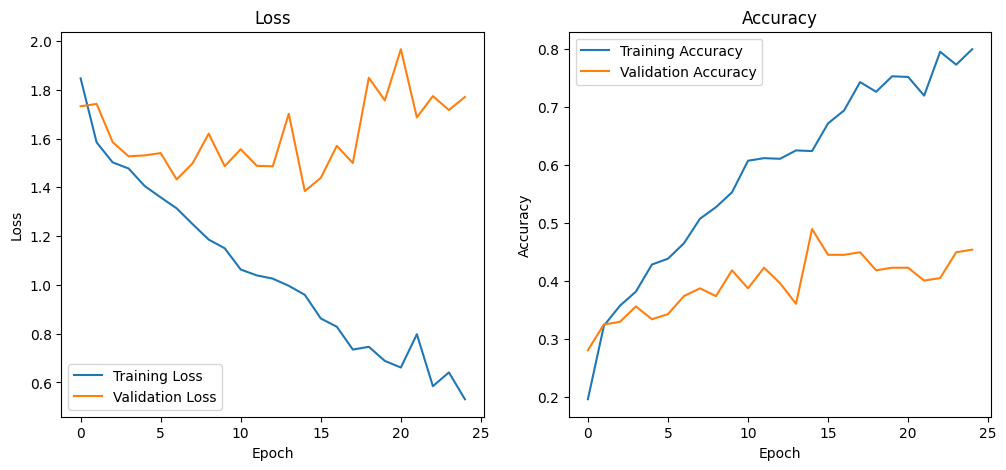

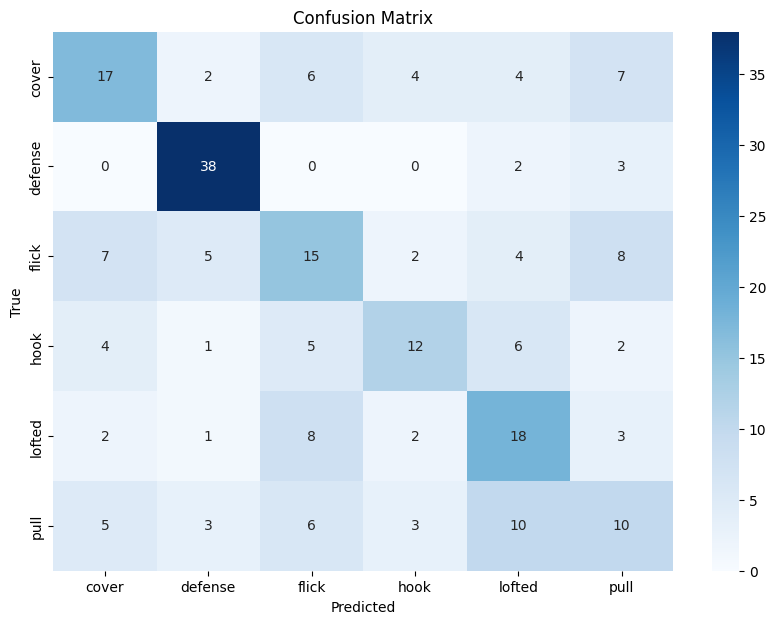

In [13]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/loss_plot.png')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/accuracy_plot.png')

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=shot_types, yticklabels=shot_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/confusion_matrix.png')
plt.show()


In [14]:
import cv2
import moviepy.editor as mp

# Function to classify frames
def classify_frames(frames):
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(frames)
    return np.argmax(predictions, axis=1)

In [19]:
match_video_path = '/content/drive/MyDrive/HonkongSuperSixesPakvsAusVideo.mp4'
cap = cv2.VideoCapture(match_video_path)
frames = []
classified_shots = []
output_dir = '/content/drive/MyDrive/shot_clips/MobileNetV2/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clip_counter = {shot: 0 for shot in shot_types}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (224, 224))
    frames.append(frame)
    if len(frames) == 16:  # Assuming each sequence has 16 frames
        frames_array = np.array(frames)
        frames_array = pad_or_truncate_frames(frames_array, max_length)
        shot_type_index = classify_frames(frames_array)[0]  # Get the predicted shot type index
        shot_type = shot_types[shot_type_index]

        # Save the clip
        clip_counter[shot_type] += 1
        clip_filename = f"{shot_type}_{clip_counter[shot_type]:04d}.mp4"
        clip_path = os.path.join(output_dir, clip_filename)
        clip = mp.ImageSequenceClip([cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames], fps=30)
        clip.write_videofile(clip_path, codec="libx264")

        classified_shots.append((shot_type, frames.copy()))
        frames = []

cap.release()

print(f"Clips saved in directory: {output_dir}")

1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0001.mp4
1/1 [==============================] - 0s 27ms/step


Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0002.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0003.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0004.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0005.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0005.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0005.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0006.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0006.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0006.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0007.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0007.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0007.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0008.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0008.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0008.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0009.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0009.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0009.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0001.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0010.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0010.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0010.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0011.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0011.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0011.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0012.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0012.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0012.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0002.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0003.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0004.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0005.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0005.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0005.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0013.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0013.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0013.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0001.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0002.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0003.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0004.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0005.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0005.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0005.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0006.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0006.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0006.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0007.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0007.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0007.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0014.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0014.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0014.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0015.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0015.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0015.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0016.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0016.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0016.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0017.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0017.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0017.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0018.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0018.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0018.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0008.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0008.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0008.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0019.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0019.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0019.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0006.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0006.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0006.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0009.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0009.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0009.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0020.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0020.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0020.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0007.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0007.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0007.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0008.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0008.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0008.mp4


1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0009.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0009.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0009.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0010.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0010.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0010.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0021.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0021.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0021.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0022.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0022.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0022.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0023.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0023.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0023.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0024.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0024.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0024.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0025.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0025.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0025.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0026.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0026.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0026.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0027.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0027.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0027.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0001.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0028.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0028.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0028.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0029.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0029.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0029.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0002.mp4


1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0010.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0010.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0010.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0003.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0004.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0005.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0005.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0005.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0011.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0011.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0011.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0030.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0030.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0030.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0031.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0031.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0031.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0012.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0012.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0012.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0013.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0013.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0013.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0014.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0014.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0014.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0015.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0015.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0015.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0016.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0016.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0016.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0032.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0032.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0032.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0006.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0006.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0006.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0011.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0011.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0011.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0033.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0033.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0033.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0034.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0034.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0034.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0035.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0035.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0035.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0036.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0036.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0036.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0007.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0007.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0007.mp4
1/1 [==============================] - 0s 28ms/step


Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0008.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0008.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0008.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0037.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0037.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0037.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0038.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0038.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0038.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0039.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0039.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0039.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0040.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0040.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0040.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0041.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0041.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0041.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0042.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0042.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0042.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0012.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0012.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0012.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0043.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0043.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0043.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0044.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0044.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0044.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0045.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0045.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0045.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0046.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0046.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0046.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0047.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0047.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0047.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0048.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0048.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0048.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0049.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0049.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0049.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0050.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0050.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0050.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0051.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0051.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0051.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0052.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0052.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0052.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0053.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0053.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0053.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0054.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0054.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0054.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0055.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0055.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0055.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0056.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0056.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0056.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0057.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0057.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0057.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0058.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0058.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0058.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0059.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0059.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0059.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0009.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0009.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0009.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0010.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0010.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0010.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0060.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0060.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0060.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0061.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0061.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0061.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0062.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0062.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0062.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0063.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0063.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0063.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0064.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0064.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0064.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0065.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0065.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0065.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0066.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0066.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0066.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0067.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0067.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0067.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0068.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0068.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0068.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0069.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0069.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0069.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0070.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0070.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0070.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0071.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0071.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0071.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0072.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0072.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0072.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0011.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0011.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0011.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0073.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0073.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0073.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0074.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0074.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0074.mp4
1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0012.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0012.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0012.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0013.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0013.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0013.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0014.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0014.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0014.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0015.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0015.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0015.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0016.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0016.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0016.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0075.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0075.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0075.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0017.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0017.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0017.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0076.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0076.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0076.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0077.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0077.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0077.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0078.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0078.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0078.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0079.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0079.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0079.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0017.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0017.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0017.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0013.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0013.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0013.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0080.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0080.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0080.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0018.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0018.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0018.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0019.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0019.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0019.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0014.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0014.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0014.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0015.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0015.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0015.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0020.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0020.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0020.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0081.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0081.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0081.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0082.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0082.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0082.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0083.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0083.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0083.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0084.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0084.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0084.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0018.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0018.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0018.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0001.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0085.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0085.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0085.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0021.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0021.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0021.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0022.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0022.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0022.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0086.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0086.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0086.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0023.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0023.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0023.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0087.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0087.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0087.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0088.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0088.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0088.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0089.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0089.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0089.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0090.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0090.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0090.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0091.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0091.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0091.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0092.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0092.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0092.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0024.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0024.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0024.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0025.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0025.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0025.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0002.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0093.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0093.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0093.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0094.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0094.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0094.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0016.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0016.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0016.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0095.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0095.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0095.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0096.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0096.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0096.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0097.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0097.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0097.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0019.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0019.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0019.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0017.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0017.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0017.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0018.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0018.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0018.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0098.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0098.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0098.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0099.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0099.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0099.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0100.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0100.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0100.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0101.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0101.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0101.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0102.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0102.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0102.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0103.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0103.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0103.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0104.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0104.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0104.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0105.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0105.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0105.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0106.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0106.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0106.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0107.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0107.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0107.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0108.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0108.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0108.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0026.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0026.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0026.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0027.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0027.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0027.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0019.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0019.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0019.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0020.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0020.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0020.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0021.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0021.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0021.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0109.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0109.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0109.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0110.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0110.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0110.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0003.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0020.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0020.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0020.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0021.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0021.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0021.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0111.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0111.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0111.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0112.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0112.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0112.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0113.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0113.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0113.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0114.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0114.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0114.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0115.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0115.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0115.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0116.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0116.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0116.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0117.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0117.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0117.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0118.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0118.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0118.mp4
1/1 [==============================] - 0s 26ms/step


Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0119.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0119.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0119.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0120.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0120.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0120.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0121.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0121.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0121.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0122.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0122.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0122.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0123.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0123.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0123.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0124.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0124.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0124.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0125.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0125.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0004.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0126.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0126.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0126.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0127.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0127.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0127.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0128.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0128.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0128.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0129.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0129.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0129.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0028.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0028.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0028.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0029.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0029.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0029.mp4
1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0030.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0030.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0030.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0022.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0022.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0022.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0031.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0031.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0031.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0032.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0032.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0032.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0033.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0033.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0033.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0130.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0130.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0130.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0023.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0023.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0023.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0024.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0024.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0024.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0025.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0025.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0025.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0034.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0034.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0034.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0131.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0131.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0131.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0132.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0132.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0132.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0133.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0133.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0133.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0134.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0134.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0134.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0135.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0135.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0135.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0136.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0136.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0136.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0137.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0137.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0137.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0035.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0035.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0035.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0022.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0022.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0022.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0023.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0023.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0023.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0138.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0138.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0138.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0024.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0024.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0024.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0139.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0139.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0139.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0140.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0140.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0140.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0141.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0141.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0141.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0005.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0005.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0005.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0142.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0142.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0142.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0025.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0025.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0025.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0143.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0143.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0143.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0144.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0144.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0144.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0145.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0145.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0145.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0146.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0146.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0146.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0147.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0147.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0147.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0148.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0148.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0148.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0149.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0149.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0149.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0150.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0150.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0150.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0151.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0151.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0151.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0036.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0036.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0036.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0037.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0037.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0037.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0038.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0038.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0038.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0039.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0039.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0039.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0026.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0026.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0026.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0006.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0006.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0006.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0152.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0152.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0152.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0026.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0026.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0026.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0040.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0040.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0040.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0153.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0153.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0153.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0154.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0154.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0154.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0155.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0155.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0155.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0156.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0156.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0156.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0027.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0027.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0027.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0157.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0157.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0157.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0158.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0158.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0158.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0159.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0159.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0159.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0027.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0027.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0027.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0160.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0160.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0160.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0161.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0161.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0161.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0162.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0162.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0162.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0163.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0163.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0163.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0164.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0164.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0164.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0041.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0041.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0041.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0165.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0165.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0165.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0007.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0007.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0007.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0008.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0008.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0008.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0028.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0028.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0028.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0009.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0009.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0009.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0166.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0166.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0166.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0167.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0167.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0167.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0029.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0029.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0029.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0042.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0042.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0042.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0043.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0043.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0043.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0044.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0044.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0044.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0030.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0030.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0030.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0168.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0168.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0168.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0001.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0001.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0001.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0045.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0045.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0045.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0046.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0046.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0046.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0047.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0047.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0047.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0169.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0169.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0169.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0170.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0170.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0170.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0028.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0028.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0028.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0029.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0029.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0029.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0030.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0030.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0030.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0031.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0031.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0031.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0171.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0171.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0171.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0172.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0172.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0172.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0173.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0173.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0173.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0048.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0048.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0048.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0174.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0174.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0174.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0175.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0175.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0175.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0049.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0049.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0049.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0050.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0050.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0050.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0176.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0176.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0176.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0177.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0177.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0177.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0051.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0051.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0051.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0010.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0010.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0010.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0052.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0052.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0052.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0032.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0032.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0032.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0033.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0033.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0033.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0178.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0178.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0178.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0053.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0053.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0053.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0054.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0054.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0054.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0179.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0179.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0179.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0180.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0180.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0180.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0181.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0181.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0181.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0182.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0182.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0182.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0183.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0183.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0183.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0184.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0184.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0184.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0185.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0185.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0185.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0055.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0055.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0055.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0186.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0186.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0186.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0187.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0187.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0187.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0188.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0188.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0188.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0189.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0189.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0189.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0190.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0190.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0190.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0191.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0191.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0191.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0192.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0192.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0192.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0193.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0193.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0193.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0194.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0194.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0194.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0056.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0056.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0056.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0195.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0195.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0195.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0031.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0031.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0031.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0196.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0196.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0196.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0197.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0197.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0197.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0198.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0198.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0198.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0199.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0199.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0199.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0200.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0200.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0200.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0201.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0201.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0201.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0057.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0057.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0057.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0202.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0202.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0202.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0203.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0203.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0203.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0204.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0204.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0204.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0205.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0205.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0205.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0206.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0206.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0206.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0207.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0207.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0207.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0208.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0208.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0208.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0209.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0209.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0209.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0210.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0210.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0210.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0211.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0211.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0211.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0212.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0212.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0212.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0213.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0213.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0213.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0058.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0058.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0058.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0059.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0059.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0059.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0060.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0060.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0060.mp4
1/1 [==============================] - 0s 32ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0061.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0061.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0061.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0214.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0214.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0214.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0215.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0215.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0215.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0216.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0216.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0216.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0217.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0217.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0217.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0034.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0034.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0034.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0032.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0032.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0032.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0035.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0035.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0035.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0218.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0218.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0218.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0219.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0219.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0219.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0220.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0220.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0220.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0221.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0221.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0221.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0222.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0222.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0222.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0223.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0223.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0223.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0062.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0062.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0062.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0063.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0063.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0063.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0036.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0036.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0036.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0224.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0224.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0224.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0225.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0225.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0225.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0226.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0226.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0226.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0064.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0064.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0064.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0227.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0227.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0227.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0228.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0228.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0228.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0229.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0229.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0229.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0230.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0230.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0230.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0231.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0231.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0231.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0037.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0037.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0037.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0038.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0038.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0038.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0232.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0232.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0232.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0233.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0233.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0233.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0065.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0065.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0065.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0234.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0234.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0234.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0033.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0033.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0033.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0039.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0039.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0039.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0235.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0235.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0235.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0236.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0236.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0236.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0066.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0066.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0066.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0067.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0067.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0067.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0068.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0068.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0068.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0040.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0040.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0040.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0069.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0069.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0069.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0070.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0070.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0070.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0237.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0237.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0237.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0238.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0238.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0238.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0034.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0034.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0034.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0035.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0035.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0035.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0071.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0071.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0071.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0239.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0239.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0239.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0072.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0072.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0072.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0073.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0073.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0073.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0074.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0074.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0074.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0240.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0240.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0240.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0241.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0241.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0241.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0242.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0242.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0242.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0243.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0243.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0243.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0244.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0244.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0244.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0036.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0036.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0036.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0037.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0037.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0037.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0038.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0038.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0038.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0039.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0039.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0039.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0245.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0245.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0245.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0246.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0246.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0246.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0247.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0247.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0247.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0248.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0248.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0248.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0041.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0041.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0041.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0249.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0249.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0249.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0250.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0250.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0250.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0075.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0075.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0075.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0251.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0251.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0251.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0252.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0252.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0252.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0076.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0076.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0076.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0077.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0077.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0077.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0253.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0253.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0253.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0254.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0254.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0254.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0255.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0255.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0255.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0256.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0256.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0256.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0257.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0257.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0257.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0258.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0258.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0258.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0259.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0259.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0259.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0260.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0260.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0260.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0261.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0261.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0261.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0262.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0262.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0262.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0263.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0263.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0263.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0264.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0264.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0264.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0040.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0040.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0040.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0265.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0265.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0265.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0078.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0078.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0078.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0266.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0266.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0266.mp4


1/1 [==============================] - 0s 34ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0079.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0079.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0079.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0080.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0080.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0080.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0267.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0267.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0267.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0268.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0268.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0268.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0081.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0081.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0081.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0269.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0269.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0269.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0041.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0041.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0041.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0270.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0270.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0270.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0271.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0271.mp4



Moviepy - Done !


Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0271.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0272.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0272.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0272.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0273.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0273.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0273.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0002.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0002.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0002.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0042.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0042.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0042.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0082.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0082.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0082.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0083.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0083.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0083.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0274.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0274.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0274.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0043.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0043.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0043.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0275.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0275.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0275.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0084.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0084.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0084.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0276.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0276.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0276.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0042.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0042.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0042.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0043.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0043.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0043.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0277.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0277.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0277.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0278.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0278.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0278.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0279.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0279.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0279.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0280.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0280.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0280.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0044.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0044.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0044.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0045.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0045.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0045.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0044.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0044.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0044.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0281.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0281.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0281.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0282.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0282.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0282.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0283.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0283.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0283.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0085.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0085.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0085.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0284.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0284.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0284.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0285.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0285.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0285.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0286.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0286.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0286.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0287.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0287.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0287.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0288.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0288.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0288.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0289.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0289.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0289.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0290.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0290.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0290.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0046.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0046.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0046.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0291.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0291.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0291.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0086.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0086.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0086.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0047.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0047.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0047.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0048.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0048.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0048.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0292.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0292.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0292.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0293.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0293.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0293.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0087.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0087.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0087.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0294.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0294.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0294.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0295.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0295.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0295.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0296.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0296.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0296.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0297.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0297.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0297.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0298.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0298.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0298.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0299.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0299.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0299.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0300.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0300.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0300.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0049.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0049.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0049.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0301.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0301.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0301.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0050.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0050.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0050.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0051.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0051.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0051.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0088.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0088.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0088.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0302.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0302.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0302.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0303.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0303.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0303.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0304.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0304.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0304.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0089.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0089.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0089.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0090.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0090.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0090.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0305.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0305.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0305.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0052.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0052.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0052.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0053.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0053.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0053.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0306.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0306.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0306.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0054.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0054.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0054.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0307.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0307.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0307.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0055.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0055.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0055.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0308.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0308.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0308.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0091.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0091.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0091.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0309.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0309.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0309.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0310.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0310.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0310.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0056.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0056.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0056.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0057.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0057.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0057.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0058.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0058.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0058.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0059.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0059.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0059.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0060.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0060.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0060.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0061.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0061.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0061.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0062.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0062.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0062.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0063.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0063.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0063.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0064.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0064.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0064.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0065.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0065.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0065.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0066.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0066.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0066.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0067.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0067.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0067.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0068.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0068.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0068.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0092.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0092.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0092.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0069.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0069.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0069.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0093.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0093.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0093.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0094.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0094.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0094.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0095.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0095.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0095.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0096.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0096.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0096.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0097.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0097.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0097.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0098.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0098.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0098.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0099.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0099.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0099.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0100.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0100.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0100.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0101.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0101.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0101.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0102.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0102.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0102.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0103.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0103.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0103.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0104.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0104.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0104.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0105.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0105.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0105.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0011.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0011.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0011.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0012.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0012.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0012.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0013.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0013.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0013.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0106.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0106.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0106.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0311.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0311.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0311.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0312.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0312.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0312.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0313.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0313.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0313.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0045.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0045.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0045.mp4
1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0314.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0314.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0314.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0315.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0315.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0315.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0316.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0316.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0316.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0107.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0107.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0107.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0108.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0108.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0108.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0046.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0046.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0046.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0047.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0047.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0047.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0317.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0317.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0317.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0318.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0318.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0318.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0319.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0319.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0319.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0320.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0320.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0320.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0321.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0321.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0321.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0109.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0109.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0109.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0110.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0110.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0110.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0111.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0111.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0111.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0112.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0112.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0112.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0113.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0113.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0113.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0114.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0114.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0114.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0115.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0115.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0115.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0070.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0070.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0070.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0322.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0322.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0322.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0323.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0323.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0323.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0048.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0048.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0048.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0324.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0324.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0324.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0049.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0049.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0049.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0325.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0325.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0325.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0326.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0326.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0326.mp4
1/1 [==============================] - 0s 32ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0327.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0327.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0327.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0328.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0328.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0328.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0329.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0329.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0329.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0014.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0014.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0014.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0330.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0330.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0330.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0050.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0050.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0050.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0051.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0051.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0051.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0331.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0331.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0331.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0332.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0332.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0332.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0071.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0071.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0071.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0116.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0116.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0116.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0117.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0117.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0117.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0118.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0118.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0118.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0052.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0052.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0052.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0053.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0053.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0053.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0333.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0333.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0333.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0334.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0334.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0334.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0335.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0335.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0335.mp4


1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0336.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0336.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0336.mp4
1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0337.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0337.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0337.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0338.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0338.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0338.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0339.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0339.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0339.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0340.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0340.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0340.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0341.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0341.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0341.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0342.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0342.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0342.mp4
1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0343.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0343.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0343.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0054.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0054.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0054.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0344.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0344.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0344.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0345.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0345.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0345.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0119.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0119.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0119.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0072.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0072.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0072.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0073.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0073.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0073.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0074.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0074.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0074.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0120.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0120.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0120.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0121.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0121.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0121.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0346.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0346.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0346.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0347.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0347.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0347.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0348.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0348.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0348.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0349.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0349.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0349.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0350.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0350.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0350.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0351.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0351.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0351.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0352.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0352.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0352.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0055.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0055.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0055.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0353.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0353.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0353.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0354.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0354.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0354.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0355.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0355.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0355.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0356.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0356.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0356.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0357.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0357.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0357.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0122.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0122.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0122.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0358.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0358.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0358.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0075.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0075.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0075.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0015.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0015.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0015.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0359.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0359.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0359.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0360.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0360.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0360.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0361.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0361.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0361.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0362.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0362.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0362.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0076.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0076.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0076.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0363.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0363.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0363.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0364.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0364.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0364.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0365.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0365.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0365.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0366.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0366.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0366.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0367.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0367.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0367.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0368.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0368.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0368.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0369.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0369.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0369.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0370.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0370.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0370.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0077.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0077.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0077.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0078.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0078.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0078.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0056.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0056.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0056.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0371.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0371.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0371.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0123.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0123.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0123.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0124.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0124.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0124.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0125.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0125.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0372.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0372.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0372.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0373.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0373.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0373.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0057.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0057.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0057.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0374.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0374.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0374.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0375.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0375.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0375.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0376.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0376.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0376.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0058.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0058.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0058.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0079.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0079.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0079.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0377.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0377.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0377.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0378.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0378.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0378.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0080.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0080.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0080.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0081.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0081.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0081.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0126.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0126.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0126.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0127.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0127.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0127.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0379.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0379.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0379.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0059.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0059.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0059.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0380.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0380.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0380.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0381.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0381.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0381.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0128.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0128.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0128.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0382.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0382.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0382.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0129.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0129.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0129.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0130.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0130.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0130.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0131.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0131.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0131.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0383.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0383.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0383.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0384.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0384.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0384.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0385.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0385.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0385.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0082.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0082.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0082.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0083.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0083.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0083.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0084.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0084.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0084.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0386.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0386.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0386.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0387.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0387.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0387.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0388.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0388.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0388.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0389.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0389.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0389.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0390.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0390.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0390.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0085.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0085.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0085.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0391.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0391.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0391.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0392.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0392.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0392.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0393.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0393.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0393.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0394.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0394.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0394.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0395.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0395.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0395.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0132.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0132.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0132.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0396.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0396.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0396.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0397.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0397.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0397.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0398.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0398.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0398.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0399.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0399.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0399.mp4
1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0133.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0133.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0133.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0086.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0086.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0086.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0087.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0087.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0087.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0088.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0088.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0088.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0089.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0089.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0089.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0400.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0400.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0400.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0401.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0401.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0401.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0402.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0402.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0402.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0403.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0403.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0403.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0404.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0404.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0404.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0405.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0405.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0405.mp4


1/1 [==============================] - 0s 33ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0406.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0406.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0406.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0090.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0090.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0090.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0091.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0091.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0091.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0407.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0407.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0407.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0408.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0408.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0408.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0409.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0409.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0409.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0410.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0410.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0410.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0411.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0411.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0411.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0412.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0412.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0412.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0413.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0413.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0413.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0092.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0092.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0092.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0414.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0414.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0414.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0415.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0415.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0415.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0416.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0416.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0416.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0417.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0417.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0417.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0418.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0418.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0418.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0419.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0419.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0419.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0420.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0420.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0420.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0421.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0421.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0421.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0422.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0422.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0422.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0423.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0423.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0423.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0093.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0093.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0093.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0424.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0424.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0424.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0425.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0425.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0425.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0426.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0426.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0426.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0427.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0427.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0427.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0428.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0428.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0428.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0429.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0429.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0429.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0430.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0430.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0430.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0134.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0134.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0134.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0060.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0060.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0060.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0431.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0431.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0431.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0094.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0094.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0094.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0095.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0095.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0095.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0096.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0096.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0096.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0135.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0135.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0135.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0136.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0136.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0136.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0137.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0137.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0137.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0432.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0432.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0432.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0433.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0433.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0433.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0434.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0434.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0434.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0435.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0435.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0435.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0436.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0436.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0436.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0437.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0437.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0437.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0438.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0438.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0438.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0439.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0439.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0439.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0440.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0440.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0440.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0441.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0441.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0441.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0442.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0442.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0442.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0061.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0061.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0061.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0443.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0443.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0443.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0444.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0444.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0444.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0062.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0062.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0062.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0445.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0445.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0445.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0097.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0097.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0097.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0098.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0098.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0098.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0099.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0099.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0099.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0446.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0446.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0446.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0447.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0447.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0447.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0448.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0448.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0448.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0449.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0449.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0449.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0450.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0450.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0450.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0451.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0451.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0451.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0452.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0452.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0452.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0453.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0453.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0453.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0454.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0454.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0454.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0100.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0100.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0100.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0063.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0063.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0063.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0064.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0064.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0064.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0065.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0065.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0065.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0455.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0455.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0455.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0138.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0138.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0138.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0456.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0456.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0456.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0457.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0457.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0457.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0458.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0458.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0458.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0139.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0139.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0139.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0140.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0140.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0140.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0459.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0459.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0459.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0460.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0460.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0460.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0461.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0461.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0461.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0462.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0462.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0462.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0463.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0463.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0463.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0101.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0101.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0101.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0464.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0464.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0464.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0102.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0102.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0102.mp4


1/1 [==============================] - 0s 33ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0465.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0465.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0465.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0466.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0466.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0466.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0467.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0467.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0467.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0468.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0468.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0468.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0469.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0469.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0469.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0470.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0470.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0470.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0471.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0471.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0471.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0472.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0472.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0472.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0473.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0473.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0473.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0474.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0474.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0474.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0475.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0475.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0475.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0476.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0476.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0476.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0477.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0477.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0477.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0478.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0478.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0478.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0479.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0479.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0479.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0480.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0480.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0480.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0481.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0481.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0481.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0482.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0482.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0482.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0483.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0483.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0483.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0484.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0484.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0484.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0485.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0485.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0485.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0486.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0486.mp4



Moviepy - Done !


Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0486.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0103.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0103.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0103.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0487.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0487.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0487.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0104.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0104.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0104.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0105.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0105.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0105.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0106.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0106.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0106.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0488.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0488.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0488.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0489.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0489.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0489.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0490.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0490.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0490.mp4


1/1 [==============================] - 0s 31ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0491.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0491.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0491.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0107.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0107.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0107.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0108.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0108.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0108.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0109.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0109.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0109.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0110.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0110.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0110.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0111.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0111.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0111.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0112.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0112.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0112.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0113.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0113.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0113.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0492.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0492.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0492.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0493.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0493.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0493.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0494.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0494.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0494.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0495.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0495.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0495.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0496.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0496.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0496.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0497.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0497.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0497.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0498.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0498.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0498.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0114.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0114.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0114.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0499.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0499.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0499.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0500.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0500.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0500.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0501.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0501.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0501.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0502.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0502.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0502.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0503.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0503.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0503.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0141.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0141.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0141.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0504.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0504.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0504.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0505.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0505.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0505.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0506.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0506.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0506.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0507.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0507.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0507.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0508.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0508.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0508.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0509.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0509.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0509.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0510.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0510.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0510.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0511.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0511.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0511.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0512.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0512.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0512.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0513.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0513.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0513.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0142.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0142.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0142.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0143.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0143.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0143.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0514.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0514.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0514.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0515.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0515.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0515.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0144.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0144.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0144.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0145.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0145.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0145.mp4


1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0146.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0146.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0146.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0516.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0516.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0516.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0147.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0147.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0147.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0517.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0517.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0517.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0518.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0518.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0518.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0519.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0519.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0519.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0520.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0520.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0520.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0521.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0521.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0521.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0522.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0522.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0522.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0523.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0523.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0523.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0524.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0524.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0524.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0525.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0525.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0525.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0526.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0526.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0526.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0527.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0527.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0527.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0528.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0528.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0528.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0529.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0529.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0529.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0530.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0530.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0530.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0531.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0531.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0531.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0532.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0532.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0532.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0533.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0533.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0533.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0534.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0534.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0534.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0115.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0115.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0115.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0116.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0116.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0116.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0117.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0117.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0117.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0148.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0148.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0148.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0149.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0149.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0149.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0150.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0150.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0150.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0535.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0535.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0535.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0151.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0151.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0151.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0536.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0536.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0536.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0537.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0537.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0537.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0538.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0538.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0538.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0539.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0539.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0539.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0540.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0540.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0540.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0541.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0541.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0541.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0066.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0066.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0066.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0118.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0118.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0118.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0067.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0067.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0067.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0119.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0119.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0119.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0120.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0120.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0120.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0121.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0121.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0121.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0122.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0122.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0122.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0542.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0542.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0542.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0543.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0543.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0543.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0544.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0544.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0544.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0545.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0545.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0545.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0546.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0546.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0546.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0547.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0547.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0547.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0068.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0068.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0068.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0548.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0548.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0548.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0549.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0549.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0549.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0550.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0550.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0550.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0551.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0551.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0551.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0552.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0552.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0552.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0553.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0553.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0553.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0554.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0554.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0554.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0555.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0555.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0555.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0556.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0556.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0556.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0557.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0557.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0557.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0558.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0558.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0558.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0559.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0559.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0559.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0560.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0560.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0560.mp4
1/1 [==============================] - 0s 31ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0561.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0561.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0561.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0562.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0562.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0562.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0563.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0563.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0563.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0564.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0564.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0564.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0069.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0069.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0069.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0565.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0565.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0565.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0152.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0152.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0152.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0153.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0153.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0153.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0566.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0566.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0566.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0123.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0123.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0123.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0070.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0070.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0070.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0567.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0567.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0567.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0568.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0568.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0568.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0071.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0071.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0071.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0569.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0569.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0569.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0072.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0072.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0072.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0154.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0154.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0154.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0073.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0073.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0073.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0155.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0155.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0155.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0074.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0074.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0074.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0075.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0075.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0075.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0076.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0076.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0076.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0570.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0570.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0570.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0571.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0571.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0571.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0572.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0572.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0572.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0016.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0016.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0016.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0156.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0156.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0156.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0077.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0077.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0077.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0078.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0078.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0078.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0573.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0573.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0573.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0574.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0574.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0574.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0575.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0575.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0575.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0576.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0576.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0576.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0577.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0577.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0577.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0578.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0578.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0578.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0579.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0579.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0579.mp4


1/1 [==============================] - 0s 31ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0157.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0157.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0157.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0580.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0580.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0580.mp4


1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0581.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0581.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0581.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0582.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0582.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0582.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0583.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0583.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0583.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0584.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0584.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0584.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0585.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0585.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0585.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0586.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0586.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0586.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0587.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0587.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0587.mp4
1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0588.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0588.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0588.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0589.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0589.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0589.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0590.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0590.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0590.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0591.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0591.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0591.mp4


1/1 [==============================] - 0s 29ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0592.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0592.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0592.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0158.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0158.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0158.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0159.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0159.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0159.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0160.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0160.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0160.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0593.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0593.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0593.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0594.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0594.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0594.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0079.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0079.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/lofted_0079.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0161.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0161.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0161.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0595.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0595.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0595.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0596.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0596.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0596.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0597.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0597.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0597.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0598.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0598.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0598.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0599.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0599.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0599.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0600.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0600.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0600.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0601.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0601.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0601.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0602.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0602.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0602.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0603.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0603.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0603.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0604.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0604.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0604.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0605.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0605.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0605.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0606.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0606.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0606.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0607.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0607.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0607.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0608.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0608.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0608.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0609.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0609.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0609.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0610.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0610.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0610.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0611.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0611.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0611.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0612.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0612.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0612.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0162.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0162.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0162.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0613.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0613.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0613.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0614.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0614.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0614.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0615.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0615.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0615.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0616.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0616.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0616.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0617.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0617.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0617.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0618.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0618.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0618.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0619.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0619.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0619.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0620.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0620.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0620.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0621.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0621.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0621.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0622.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0622.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0622.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0623.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0623.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0623.mp4


1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0624.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0624.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0624.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0625.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0625.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0625.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0626.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0626.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0626.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0627.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0627.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0627.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0628.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0628.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0628.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0629.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0629.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0629.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0630.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0630.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0630.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0631.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0631.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0631.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0632.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0632.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0632.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0163.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0163.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0163.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0633.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0633.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0633.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0634.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0634.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0634.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0635.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0635.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0635.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0636.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0636.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0636.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0637.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0637.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0637.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0003.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0003.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0003.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0638.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0638.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0638.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0639.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0639.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0639.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0640.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0640.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0640.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0641.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0641.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0641.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0164.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0164.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0164.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0165.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0165.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0165.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0017.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0017.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0017.mp4


1/1 [==============================] - 0s 30ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0166.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0166.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0166.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0642.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0642.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0642.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0167.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0167.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0167.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0643.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0643.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0643.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0644.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0644.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0644.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0124.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0124.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0124.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0125.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0125.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0126.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0126.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0126.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0645.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0645.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0645.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0646.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0646.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0646.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0647.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0647.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0647.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0127.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0127.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0127.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0128.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0128.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0128.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0648.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0648.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0648.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0649.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0649.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0649.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0129.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0129.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0129.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0650.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0650.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0650.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0018.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0018.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0018.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0168.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0168.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0168.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0019.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0019.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/hook_0019.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0130.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0130.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0130.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0651.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0651.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0651.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0652.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0652.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0652.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0653.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0653.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0653.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0654.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0654.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0654.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0655.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0655.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0655.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0656.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0656.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0656.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0657.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0657.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0657.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0658.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0658.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0658.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0169.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0169.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/cover_0169.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0659.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0659.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0659.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0660.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0660.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0660.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0661.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0661.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0661.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0662.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0662.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0662.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0663.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0663.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0663.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0664.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0664.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0664.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0665.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0665.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0665.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0666.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0666.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0666.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0667.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0667.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0667.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0668.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0668.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0668.mp4
1/1 [==============================] - 0s 28ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0669.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0669.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0669.mp4
1/1 [==============================] - 0s 24ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0670.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0670.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0670.mp4
1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0671.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0671.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0671.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0672.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0672.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0672.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0673.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0673.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0673.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0131.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0131.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0131.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0674.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0674.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0674.mp4


1/1 [==============================] - 0s 27ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0675.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0675.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0675.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0676.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0676.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0676.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0677.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0677.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0677.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0132.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0132.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0132.mp4


1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0133.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0133.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0133.mp4
1/1 [==============================] - 0s 26ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0004.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0004.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/defense_0004.mp4


1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0678.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0678.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/pull_0678.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0134.mp4.
Moviepy - Writing video /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0134.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/shot_clips/MobileNetV2/flick_0134.mp4
Clips saved in directory: /content/drive/MyDrive/shot_clips/MobileNetV2/


In [5]:
# # Extract and save clips based on classified shots
# highlight_clips = []
# clip_no = 0
# for shot_type, shot_frames in classified_shots:
#     if shot_type in [0, 1, 2, 3, 4, 5]:  # Example: Include all shot types in highlights

#         highlight_clip = mp.ImageSequenceClip([cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in shot_frames], fps=30)
#         highlight_clip.write_videofile("/content/highlights"+ str(clip_no) +".mp4")
#         highlight_clips.append(highlight_clip)
#         clip_no += 1

In [6]:
# # Combine highlight clips to create final highlight video
# final_clip = mp.concatenate_videoclips(highlight_clips)
# final_clip.write_videofile("/content/match_highlights.mp4")

In [17]:
from sklearn.metrics import classification_report

# Evaluate model on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes, target_names=shot_types))


8/8 [==============================] - 3s 414ms/step
              precision    recall  f1-score   support

       cover       0.49      0.42      0.45        40
     defense       0.76      0.88      0.82        43
       flick       0.38      0.37      0.37        41
        hook       0.52      0.40      0.45        30
      lofted       0.41      0.53      0.46        34
        pull       0.30      0.27      0.29        37

    accuracy                           0.49       225
   macro avg       0.48      0.48      0.47       225
weighted avg       0.48      0.49      0.48       225



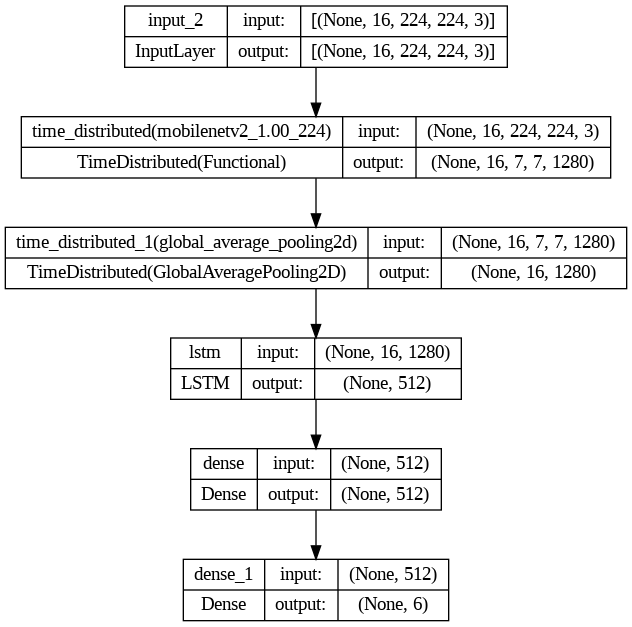

In [18]:
# prompt: plotmodel

import tensorflow as tf
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, show_shapes=True)
